# Entity Linking Pipeline for [DisTEMIST](https://temu.bsc.es/distemist/) Shared Task (10th BioASQ Workshop)

The goal is to link disease mentions in Spanish case reports to SNOMED CT IDs.

Highlights:
- Building a custom dictionary based on the (non-UMLS) DisTEMIST gazetteer + multilingual UMLS synonyms
- Using an Ensemble of TFIDFNgramLinker + SapBERTLinker
- Reranking with a trainable CrossEncoderReranker
- Evaluation and Error Analysis

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from pathlib import Path

In [3]:
from xmen.evaluation import entity_linking_error_analysis, evaluate_at_k
from xmen.linkers.util import filter_and_apply_threshold

**Note**: adapt `umls_meta_path` in `../conf/distemist.yaml` to point to the location of your UMLS release (you might want to set the environment variable `$UMLS_HOME`)

In [4]:
from xmen.confhelper import load_config
config = load_config('../conf/distemist.yaml')
base_path = Path(config.cache_dir)
tmp_path = Path('..') / 'temp' / 'distemist'

In [5]:
import datasets

ds = datasets.load_dataset('distemist', 'distemist_linking_bigbio_kb')

# Own validation set (20% of distemist training set / EL sub-track)
with open('distemist_validation_docs.txt', 'r') as fh:
    valid_ids = [l.strip() for l in fh.readlines()]
    
ds_train = ds['train'].filter(lambda d: d['document_id'] not in valid_ids)
ds_valid = ds['train'].filter(lambda d: d['document_id'] in valid_ids)

ds['train'] = ds_train
ds['validation'] = ds_valid

ds

Using the latest cached version of the module from /home/Florian.Borchert/.cache/huggingface/modules/datasets_modules/datasets/distemist/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd (last modified on Thu Apr 20 13:14:35 2023) since it couldn't be found locally at distemist., or remotely on the Hugging Face Hub.
Found cached dataset distemist (/home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-39869da4ad369074.arrow
Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-955d26b050eff51d.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 466
    })
    test: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 117
    })
})

# Preparation - Just run once

__Note__: This is a bit more involved, because we dynamically explore different combinations of DisTEMIST gazetteer and UMLS subsets.

In most normal cases, you just want to configure the target dictionary in your .yaml file and run `xmen dict` and `xmen index` with default settings.

## Download Distemist gazetteer

In [6]:
!mkdir -p ../temp; wget https://zenodo.org/record/6505583/files/dictionary_distemist.tsv?download=0 -O ../temp/dictionary_distemist.tsv

--2023-06-06 21:02:55--  https://zenodo.org/record/6505583/files/dictionary_distemist.tsv?download=0
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9885605 (9.4M) [application/octet-stream]
Saving to: ‘../temp/dictionary_distemist.tsv’

../temp/dictionary_ 100%[===================>]   9.43M  3.44MB/s    in 2.7s    

2023-06-06 21:02:58 (3.44 MB/s) - ‘../temp/dictionary_distemist.tsv’ saved [9885605/9885605]



## Setup dictionaries

Since the DisTEMIST Task only covers a subset of SNOMED CT codes, we retrieve only additional synonyms for the UMLS for these codes.
Thus, we need to map CUIs to SNOMED CT IDs and merge them with the DisTEMIST gazetteer.

In [7]:
dict_configs = ['distemist_gazetteer', 'distemist_umls_es', 'distemist_umls_en_es', 'distemist_umls_all'] 

In [8]:
from IPython.display import Markdown, display

# Run these commands from the root folder
for d in dict_configs:
    display(Markdown(f"`xmen dict conf/distemist.yaml --code dicts/distemist.py --key {d}`"))

`xmen dict conf/distemist.yaml --code dicts/distemist.py --key distemist_gazetteer`

`xmen dict conf/distemist.yaml --code dicts/distemist.py --key distemist_umls_es`

`xmen dict conf/distemist.yaml --code dicts/distemist.py --key distemist_umls_en_es`

`xmen dict conf/distemist.yaml --code dicts/distemist.py --key distemist_umls_all`

In [9]:
meta_path = Path(config.umls_meta_path)

In [10]:
from collections import defaultdict
from tqdm.auto import tqdm
from xmen.umls import read_umls_file_headers

def read_cui2snomed_mapping(meta_path):
    mrconso = 'MRCONSO.RRF'
    cui2snomed = defaultdict(list)
    headers = read_umls_file_headers(meta_path, mrconso)
    with open(f"{meta_path}/{mrconso}") as fin:
        for line in tqdm(fin.readlines()):
            splits = line.strip().split("|")
            assert len(headers) == len(splits)
            concept = dict(zip(headers, splits))
            if concept['SAB'] in ['SNOMEDCT_US', 'SCTSPA']:
                cui2snomed[concept['CUI']].append(concept['SCUI'])
    return cui2snomed

In [11]:
cui2snomed_mapping = read_cui2snomed_mapping(meta_path)

  0%|          | 0/16857345 [00:00<?, ?it/s]

In [12]:
import json
from tqdm.auto import tqdm
from xmen.kb import CompositeKnowledgebase

def cui2snomed(entry):
    res = []
    cui = entry['concept_id']
    for sctid in cui2snomed_mapping[cui]:
        r = entry.copy()
        r['concept_id'] = sctid
        res.append(r)
    return res

def merge_and_write_dicts(target_jsonl, added_jsonl, output_jsonl):
    print(f'Writing to {output_jsonl}')
    output_jsonl.parent.mkdir(exist_ok=True, parents=True)
    cui_count = alias_count = 0
    kb = CompositeKnowledgebase([added_jsonl], mappers=[cui2snomed])
    with open(output_jsonl, 'w') as fo:
        for l in tqdm(list(open(target_jsonl).readlines())):
            cui_count += 1
            entry = json.loads(l)
            sctid = str(entry['concept_id'])
            if sctid in kb.cui_to_entity:
                concept = kb.cui_to_entity[sctid]
                known_aliases = [entry['canonical_name']] + entry['aliases']
                new_aliases = [c for c in [concept.canonical_name] + concept.aliases if c not in known_aliases]
            else:
                new_aliases = []
            entry['aliases'] += new_aliases
            alias_count += (len(entry['aliases']) + 1)
            fo.write(json.dumps(entry) + '\n')
    print(f'Written {cui_count} concepts with {alias_count} aliases')

In [13]:
distemist_gazetteer_jsonl = base_path / 'distemist_gazetteer' / 'distemist_gazetteer.jsonl'

In [14]:
for d in dict_configs[1:]:
    merge_and_write_dicts(distemist_gazetteer_jsonl, base_path / d / f'{d}.jsonl', base_path / 'distemist' / 'merged' / f'{d}.jsonl')

Writing to /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_es.jsonl


  0%|          | 0/111179 [00:00<?, ?it/s]

Written 111179 concepts with 495324 aliases
Writing to /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_en_es.jsonl


  0%|          | 0/111179 [00:00<?, ?it/s]

Written 111179 concepts with 1520890 aliases
Writing to /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_all.jsonl


  0%|          | 0/111179 [00:00<?, ?it/s]

Written 111179 concepts with 2482643 aliases


## Prepare TF-IDF NGram and SapBERT indices for all configurations

In [15]:
# Run these commands from the root folder
display(Markdown(f"`xmen index conf/distemist.yaml --dict {base_path / 'distemist_gazetteer' / 'distemist_gazetteer.jsonl'} --output {base_path / 'distemist' / 'merged' / 'distemist_gazetteer'} --all`"))
for d in dict_configs[1:]:
    display(Markdown(f"`xmen index conf/distemist.yaml --dict {base_path / 'distemist' / 'merged' / f'{d}.jsonl'} --output {base_path / 'distemist' / 'merged' / f'{d}'} --all`"))

`xmen index conf/distemist.yaml --dict /home/Florian.Borchert/.cache/xmen/distemist_gazetteer/distemist_gazetteer.jsonl --output /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_gazetteer --all`

`xmen index conf/distemist.yaml --dict /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_es.jsonl --output /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_es --all`

`xmen index conf/distemist.yaml --dict /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_en_es.jsonl --output /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_en_es --all`

`xmen index conf/distemist.yaml --dict /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_all.jsonl --output /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls_all --all`

# Pre-Processing

In [16]:
from xmen.data import AbbreviationExpander

ds = AbbreviationExpander().transform_batch(ds)

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-ebcef6df9b7ffc92.arrow
Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-2119267e890fbfb9.arrow
Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-f045e9486a31575e.arrow


# Candidate Generation

We configure two candidate generators:
1. `TFIDFNGramLinker`, which links surface forms based on TF-IDF scores over character ngrams
2. `SapBERTLinker`, which uses a Transformer model to retrieve candidates with dense embeddings

Finally, we combine their predictions using an `EnsembleLinker`

In [17]:
dict_config = 'distemist_umls_en_es'

In [18]:
from xmen.linkers import TFIDFNGramLinker, SapBERTLinker, EnsembleLinker
from xmen.linkers.util import filter_and_apply_threshold
from datasets import DatasetDict

In [19]:
index_base_path = base_path / 'distemist' / 'merged' / dict_config / 'index'

#### TF-IDF over character n-grams

In [20]:
ngram_linker = TFIDFNGramLinker(index_base_path=index_base_path / 'ngrams', k=100)
pred_ngram = ngram_linker.predict_batch(ds)

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

In [21]:
# Recall for different numbers of candidates (k)
_ = evaluate_at_k(ds['validation'], pred_ngram['validation'])

Perf@1 0.2919563058589871
Perf@2 0.41509433962264153
Perf@4 0.5868917576961271
Perf@8 0.6772591857000994
Perf@16 0.7259185700099305
Perf@32 0.7656405163853028
Perf@64 0.7974180734856008


#### Dense Retrieval with SapBERT

In [22]:
# Clear singleton to free up memory
SapBERTLinker.clear()
sapbert_linker = SapBERTLinker(
    index_base_path = index_base_path / 'sapbert',
    k = 1000,
    expand_abbreviations=True,
)

pred_sapbert = sapbert_linker.predict_batch(ds, batch_size=128)

[06/06/23 21:06:22] INFO     Loading hierarchical faiss index                                ]8;id=801310;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=524444;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/sap_bert_linker.py#143\143]8;;\

                    INFO     Loading index from                                                 ]8;id=36955;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=946263;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls                    
                             _en_es/index/sapbert/embed_faiss_hier.pickle                                          

[06/06/23 21:06:24] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=229130;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=583477;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 1518833                                                                          

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

In [23]:
# Recall for different numbers of candidates (k)
_ = evaluate_at_k(ds['validation'], pred_sapbert['validation'])

Perf@1 0.38629592850049654
Perf@2 0.5322740814299901
Perf@4 0.6623634558093346
Perf@8 0.7477656405163853
Perf@16 0.7944389275074478
Perf@32 0.817279046673287
Perf@64 0.8361469712015889


#### Ensemble

In [24]:
ensemble_linker = EnsembleLinker()
ensemble_linker.add_linker('sapbert', sapbert_linker, k=100)
ensemble_linker.add_linker('ngram', ngram_linker, k=100)

# Re-use predictions for efficiency
# TODO: reuse_preds currently does not work with dataset dicts
pred_ensemble = DatasetDict()
pred_ensemble['train'] = ensemble_linker.predict_batch(ds['train'], 128, 100, reuse_preds={'sapbert' : pred_sapbert['train'], 'ngram' : pred_ngram['train']})
pred_ensemble['validation'] = ensemble_linker.predict_batch(ds['validation'], 128, 100, reuse_preds={'sapbert' : pred_sapbert['validation'], 'ngram' : pred_ngram['validation']})
pred_ensemble['test'] = ensemble_linker.predict_batch(ds['test'], 128, 100, reuse_preds={'sapbert' : pred_sapbert['test'], 'ngram' : pred_ngram['test']})

pred_ensemble.save_to_disk(tmp_path / dict_config / 'pred_ensemble')

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/466 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/117 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/250 [00:00<?, ? examples/s]

In [25]:
# Recall for different numbers of candidates (k)
_ = evaluate_at_k(ds['validation'], pred_ensemble['validation'])

Perf@1 0.42800397219463754
Perf@2 0.5441906653426017
Perf@4 0.663356504468719
Perf@8 0.7517378351539226
Perf@16 0.8003972194637538
Perf@32 0.82025819265144
Perf@64 0.846077457795432


# Reranking

We use a cross-encoder to embed the mention with their context together with all potential candidates. This way, we can learn the best ranking of candidates from the training data

In [26]:
from xmen.reranking.cross_encoder import CrossEncoderReranker, CrossEncoderTrainingArgs

In [27]:
K_RERANKING = 64
CROSS_ENC_MODEL = 'PlanTL-GOB-ES/roberta-base-biomedical-clinical-es'
NUM_EPOCHS = 20

## Prepare Data for Cross-Encoder Training
Create a dataset of samples for each instance with all potential candidates

In [28]:
# Dictionary used for synonyms in entity representation. 
# Note: You may or may not use the config used for candidate generation here. We used a different one, to demonstrate the available options.
dict_config_rr = 'distemist_umls_es'

Use the ensemble predictions as candidates

In [29]:
from xmen.linkers.util import filter_and_apply_threshold

candidates = datasets.load_from_disk(tmp_path / dict_config / 'pred_ensemble')
candidates = filter_and_apply_threshold(candidates, K_RERANKING, 0.0)

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

We use the prepared KB to retrieve the synonyms per concept

In [30]:
from xmen.kb import load_kb
kb = load_kb(base_path / 'distemist' / 'merged' / f'{dict_config_rr}.jsonl')

In [31]:
cross_enc_ds = CrossEncoderReranker.prepare_data(candidates, ds, kb, encode_sem_type=True)
cross_enc_ds.save_to_disk(tmp_path / f'cross_enc_ds_{dict_config_rr}')

Context length: 128


  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/2598 [00:00<?, ?it/s]

  0%|          | 0/2598 [00:00<?, ?it/s]

  0%|          | 0/2598 [00:00<?, ?it/s]

## Train Cross Encoder

The cross-encoder is trained for 20 epochs, the final model is saved to `output_dir`

In [32]:
from xmen.data.indexed_dataset import IndexedDatasetDict
cross_enc_ds = IndexedDatasetDict.load_from_disk(tmp_path / f'cross_enc_ds_{dict_config_rr}')
cross_enc_ds

{'train': [4180 items], 'validation': [956 items], 'test': [2598 items]}

In [33]:
cross_enc_ds['train'].dataset[0][0:10]

[<ScoredInputExample> label: 0, score: 0.6854951977729797, texts:  dado de alta a los diez días de la intervención quirúrgica.
 El estudio anatomopatológico del apéndice cecal fue informado como  [START] apéndice cecal con signos inflamatorios [END] 
 
 ; disorder [TYPE] inflamación de apéndice epiploico [TITLE] inflamación de apéndice epiploico (trastorno) [SEP] Apendicitis epiploica,
 <ScoredInputExample> label: 0, score: 0.6809297800064087, texts:  dado de alta a los diez días de la intervención quirúrgica.
 El estudio anatomopatológico del apéndice cecal fue informado como  [START] apéndice cecal con signos inflamatorios [END] 
 
 ; disorder [TYPE] apendicitis crónica [TITLE] inflamación crónica del apéndice [SEP] Apendicitis crónica [SEP] apendicitis crónica (trastorno),
 <ScoredInputExample> label: 0, score: 0.6728464961051941, texts:  dado de alta a los diez días de la intervención quirúrgica.
 El estudio anatomopatológico del apéndice cecal fue informado como  [START] apéndice 

In [34]:
train_args = CrossEncoderTrainingArgs( 
    NUM_EPOCHS,
    CROSS_ENC_MODEL,
    score_regularization=True,
)

In [35]:
rr = CrossEncoderReranker()
output_dir = f'{tmp_path}/{dict_config_rr}/cross_encoder_training/'

In [36]:
# Depending on the number of epochs, this can take a few hours
rr.fit(train_args, cross_enc_ds['train'].dataset, cross_enc_ds['validation'].dataset, output_dir=output_dir, show_progress_bar=False)

model_name := PlanTL-GOB-ES/roberta-base-biomedical-clinical-es
num_train_epochs := 20
fp16 := True
label_smoothing := False
score_regularization := True
train_layers := None
softmax_loss := True
random_seed := 42


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: 

2023-06-06 21:52:55 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-06-06 21:58:11 - Accuracy: 0.5805439330543933
2023-06-06 21:58:11 - Accuracy @ 5: 0.7813807531380753
2023-06-06 21:58:11 - Accuracy @ 64: 0.8744769874476988
2023-06-06 21:58:11 - Baseline Accuracy: 0.45083682008368203
2023-06-06 21:58:11 - Save model to ../temp/distemist/distemist_umls_es/cross_encoder_training/
2023-06-06 22:33:50 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-06-06 22:39:06 - Accuracy: 0.5983263598326359
2023-06-06 22:39:06 - Accuracy @ 5: 0.7918410041841004
2023-06-06 22:39:06 - Accuracy @ 64: 0.8744769874476988
2023-06-06 22:39:06 - Baseline Accuracy: 0.45083682008368203
2023-06-06 22:39:06 - Save model to ../temp/distemist/distemist_umls_es/cross_encoder_training/
2023-06-06 23:14:45 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-06-06 23:20:02 - Accuracy: 0.6150627615062761
2023-06-06 23:20:

## Predict on Test Set

We load the final model to get predictions on the test set and run the evaluation

In [37]:
rr = CrossEncoderReranker.load(output_dir, device=0)

2023-06-07 10:55:13 - Use pytorch device: cuda


In [38]:
cross_enc_pred_valid = rr.rerank_batch(candidates['validation'], cross_enc_ds['validation'])

Batches:   0%|          | 0/956 [00:00<?, ?it/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

In [39]:
_ = evaluate_at_k(ds['validation'], cross_enc_pred_valid)

Perf@1 0.6305858987090367
Perf@2 0.6931479642502483
Perf@4 0.7586891757696127
Perf@8 0.788480635551142
Perf@16 0.8083416087388282
Perf@32 0.8341608738828202
Perf@64 0.846077457795432


In [40]:
cross_enc_pred = rr.rerank_batch(candidates['test'], cross_enc_ds['test'])

Batches:   0%|          | 0/2598 [00:00<?, ?it/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [41]:
_ = evaluate_at_k(ds['test'], cross_enc_pred)

Perf@1 0.5941761887209731
Perf@2 0.6634721710283819
Perf@4 0.7169185403612237
Perf@8 0.7464061924069296
Perf@16 0.7736822705492076
Perf@32 0.7906376704754884
Perf@64 0.8020641356431994


# Error Analysis

Using the `xmen.evaluation` module, we gain insights into different error types

In [42]:
from notebook_util import analyze
from xmen.kb import load_kb
from xmen.evaluation import entity_linking_error_analysis

In [43]:
cg_kb = load_kb(base_path / 'distemist' / 'merged' / f'{dict_config}.jsonl')

In [44]:
error_cand = entity_linking_error_analysis(ds['validation'], candidates['validation'])
edf_cand, _ = analyze(error_cand, cg_kb, 'eval', None)

In [45]:
# False negative (not part of top 64)
fns_cand = edf_cand[edf_cand.pred_index == -1]
fns_cand_counts = fns_cand.error_type.value_counts() / len(edf_cand)
fns_cand_counts

error_type
COMPLEX_ENTITY         0.117180
ABBREV                 0.014896
UNKNOWN_ERROR          0.011917
WRONG_SEMANTIC_TYPE    0.009930
Name: count, dtype: float64

In [46]:
# Ranking errors during candidate generation
misranked_cand = edf_cand[edf_cand.pred_index > 0]
misranked_cand_counts = misranked_cand.error_type.value_counts() / len(edf_cand)
misranked_cand_counts

error_type
COMPLEX_ENTITY         0.173784
WRONG_SEMANTIC_TYPE    0.119166
SAME_SYNONYMS          0.070506
UNKNOWN_ERROR          0.041708
ABBREV                 0.012910
Name: count, dtype: float64

In [47]:
# Ranking errors after reranking
error_rr = entity_linking_error_analysis(ds['validation'], cross_enc_pred_valid)
edf_rr, _ = analyze(error_rr, cg_kb, 'eval', None)

misranked_rr = edf_rr[edf_rr.pred_index > 0]
misranked_rr_counts = misranked_rr.error_type.value_counts() / len(edf_rr)
misranked_rr_counts

error_type
COMPLEX_ENTITY         0.126117
WRONG_SEMANTIC_TYPE    0.031778
SAME_SYNONYMS          0.024826
UNKNOWN_ERROR          0.020854
ABBREV                 0.011917
Name: count, dtype: float64

In [48]:
print('Recall@1', (edf_rr.pred_index == 0).sum() / len(edf_rr))
print('Recall@64', (edf_rr.pred_index >= 0).sum() / len(edf_rr))

Recall@1 0.6305858987090367
Recall@64 0.846077457795432


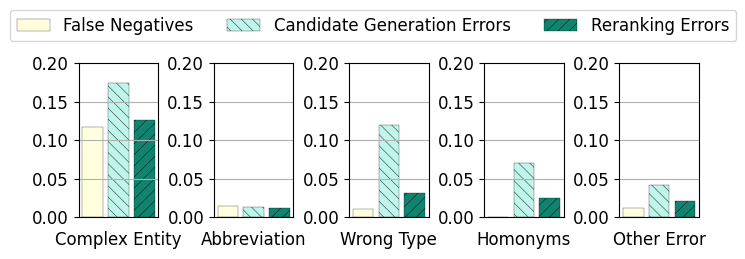

In [49]:
import matplotlib
from matplotlib import pyplot as plt

error_types = ['Complex Entity', 'Abbreviation', 'Wrong Type', 'Homonyms', 'Other Error']
keys = ['COMPLEX_ENTITY', 'ABBREV', 'WRONG_SEMANTIC_TYPE', 'SAME_SYNONYMS', 'UNKNOWN_ERROR']
counts = [fns_cand_counts, misranked_cand_counts, misranked_rr_counts]
count_names = ['False Negatives', 'Candidate Generation Errors', 'Reranking Errors']

hatches = ['', '\\\\\\', '///']
colors = ['lightyellow', '#C0F5EC', '#118470']

matplotlib.rcParams['hatch.linewidth'] = 0.3 
matplotlib.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(1, len(keys), figsize=(8, 2))
for i, (key, error) in enumerate(zip(keys, error_types)):
    for j, bar in enumerate(axs[i].bar(x=count_names, height=[c.get(key, 0.0) for c in counts], color=colors, edgecolor = 'black', linewidth=0.2)):
        bar.set_hatch(hatches[j])
    axs[i].grid(axis='y')
    axs[i].set_ylim([0.0, 0.2])
    axs[i].set_xlabel(error, labelpad=10)
    axs[i].get_xaxis().set_ticks([])
handles = [plt.Rectangle((0,0),1,1, facecolor=color, linewidth=0.2, edgecolor='black', hatch=h) for color, h in zip(colors, hatches)]
plt.legend(handles, count_names, loc='upper center', bbox_to_anchor=(-3.1, 1.4, 0, 0), ncol=len(counts))

plt.subplots_adjust(wspace=0.7)